In [72]:
from PIL import Image
import numpy as np
import random
import tensorflow as tf
from matplotlib.pyplot import imshow
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import cv2
from skimage import color
import pickle
from scipy.misc import imsave

In [3]:
def RGBtoYCC(arr):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = arr.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

In [4]:
def YCCtoRGB(arr):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = arr.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

In [5]:
def RGBtoGray(arr):
    ycc = RGBtoYCC(arr)
    ret = np.zeros_like(ycc[:, :, 0])
    ret[:, :] = ycc[:, :, 0]
    return ret

In [6]:
def YCCtoGray(arr):
    ret = np.zeros_like(arr)
    ret[:, :, 0] = arr[:, :, 0]
    ret[:, :, 1] = arr[:, :, 0]
    ret[:, :, 2] = arr[:, :, 0]
    return ret

In [7]:
def crop_center(img, cropx, cropy):
    y, x, C = img.shape
    if y > cropy and x > cropx:
        startx = x//2 - (cropx//2)
        starty = y//2 - (cropy//2)    
        return img[starty:starty+cropy, startx:startx+cropx, :]
    else:
        return None

In [2]:
train_dir = './train2017/'

num_train = 30000
image_names = os.listdir(train_dir)
image_names = image_names[:num_train]
print(len(image_names))

%matplotlib inline

30000


In [8]:
# some of the images might not be the right size
# these are the dimenions with which we are working
H = 256
W = 256
C = 3

In [9]:
def process_image(arr, H, W):
    if len(arr.shape) == 3:
        cropped = crop_center(arr, H, W)
        if cropped is not None:
            arr = RGBtoYCC(cropped)
            arr = np.divide(arr, 255)
            # arr = normalize_image(arr)
            gray = YCCtoGray(arr)
            # upped = prep_for_res(gray, H_resnet, W_resnet)
            # arr = normalize_image(arr)
            # upped = normalize_image(upped)
            return gray, arr[:, :, 1:]
        return None, None
    return None, None

In [14]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 10

print('Using device: ', device)

Using device:  /device:GPU:0


In [11]:
num_val = 100
val_folder = "./val2017"

X_val = np.zeros((num_val, H, W, C))
y_val = np.zeros((num_val, H, W, C - 1))

val_names = os.listdir(val_folder)

val_used = []

count = 0
while count < num_val:
    filename = random.choice(val_names)
    arr = np.load(os.path.join(val_folder, filename))
    x, y = process_image(arr, H, W)
    if x is not None:
        val_used.append(filename)
        X_val[count, :, :, :] = x
        y_val[count, :, :, :] = y
        count += 1
print(X_val.shape)
print(y_val.shape)
print(len(val_used))

(100, 256, 256, 3)
(100, 256, 256, 2)
100


In [69]:
lam = 1e-3
def my_loss_function(y_true, y_pred):
    loss1 = tf.keras.losses.mean_squared_error(y_true, y_pred)
    loss2 = lam * tf.keras.backend.var(y_pred)
    return loss1 + loss2

In [130]:
image_name = random.choice(val_names)
showoff = np.load(os.path.join("./val2017/", image_name))
x, y = process_image(showoff, H, W)

000000551710.npy


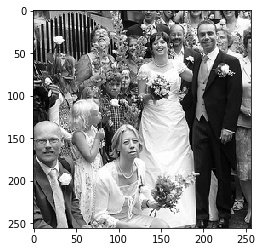

In [131]:
print(image_name)
imshow(x)

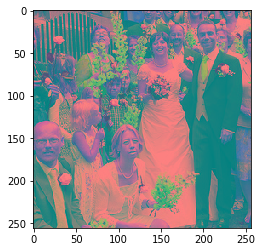

In [132]:
should_be = np.zeros((H, W, C))
should_be[:, :, 0] = x[:, :, 0]
should_be[:, :, 1] = y[:, :, 0]
should_be[:, :, 2] = y[:, :, 1]
imshow(should_be)

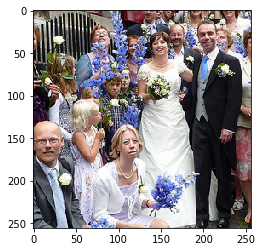

In [133]:
imshow(YCCtoRGB(255 * should_be))

In [138]:
number_of_examples = 20
for example_number in range(number_of_examples):
    image_name = random.choice(val_names)
    showoff = np.load(os.path.join("./val2017/", image_name))
    x, y = process_image(showoff, H, W)

    val_example_directory = os.path.join("./", "images_for_paper", "val_examples")
    nam = image_name.split(".")[0]
    directory_for_example = os.path.join(val_example_directory, nam)

    cont = False
    if not os.path.exists(directory_for_example):
        os.mkdir(directory_for_example)
        cont = True

    if cont:

        imsave(os.path.join(directory_for_example, "grayscale.png"), x)

        should_be = np.zeros((H, W, C))
        should_be[:, :, 0] = x[:, :, 0]
        should_be[:, :, 1] = y[:, :, 0]
        should_be[:, :, 2] = y[:, :, 1]
        imsave(os.path.join(directory_for_example, "ycc_actual.png"), should_be)
        imsave(os.path.join(directory_for_example, "rgb_actual.png"), YCCtoRGB(255 * should_be))

        name_stems = ["model_vgg", "model_inception_v2", "model_inception_v3_plain", "model_inception_v4_augmented_loss"]
        for name_stem in name_stems:
            directory_for_model = os.path.join(directory_for_example, name_stem)
            # print(directory_for_model)
            if not os.path.exists(directory_for_model):
                os.mkdir(directory_for_model)

            model_file = name_stem + '.json'
            weights_file = name_stem + '.h5'
            history_file = name_stem + '.pkl'
            loss_file = name_stem + '.png'

            model_path = os.path.join("./", model_file)
            weights_path = os.path.join("./", weights_file)

            json_string = None
            with open(model_path, 'r') as f:
                json_string = json.load(f)
            my_model = tf.keras.models.model_from_json(json_string)
            my_model.load_weights(weights_path)

            prediction = my_model.predict(x[np.newaxis, :, :, :])
            prediction = np.reshape(prediction, (H, W, 2))

            ycc_predict = np.zeros((H, W, C))
            ycc_predict[:, :, 0] = x[:, :, 0]
            ycc_predict[:, :, 1] = prediction[:, :, 0]
            ycc_predict[:, :, 2] = prediction[:, :, 1]
            ycc_predict[ycc_predict < 0] = 0
            imsave(os.path.join(directory_for_model, "ycc_predict_" + name_stem + ".png"), ycc_predict)
            imsave(os.path.join(directory_for_model, "rgb_predict_" + name_stem + ".png"), YCCtoRGB(255 * ycc_predict))
        
        print("finished number %s" % example_number)


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: DeprecationWarning: `imsave` is

finished number 0
finished number 1
finished number 2
finished number 3
finished number 4
finished number 5
finished number 6
finished number 7
finished number 8
finished number 9
finished number 10
finished number 11
finished number 12
finished number 13
finished number 14
finished number 15
finished number 16
finished number 17
finished number 18
finished number 19
